In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
import sentencepiece as spm
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import sentencepiece as spm  # pip install sentencepiece
import re
import pickle

In [6]:
%cd '/content/drive/MyDrive/Colab Notebook'

/content/drive/MyDrive/Colab Notebook


In [7]:
# news data를 읽어온다.
newsData = fetch_20newsgroups(
    shuffle=True, random_state=1, remove=('footers', 'quotes'))

In [8]:
# 첫 번째 news를 조회해 본다.
news = newsData['data']
topic = newsData['target']
topic_name = newsData['target_names']
n_topic = len(set(topic))


In [9]:
# Subject만 추출한다.
subjects = []
for text in news:
    for sent in text.split('\n'):
        idx = sent.find('Subject:')
        if idx >= 0:       # found
            subject = sent[(idx + 9):].replace('Re: ', '').lower()
            subjects.append(re.sub("[^a-zA-Z]", " ", subject))
            break

In [10]:
# Sentencepice용 사전을 만들기 위해 corpusQA를 저장해 둔다.
data_file = "data/news_subject.txt"
with open(data_file, 'w', encoding='utf-8') as f:
    for sent in subjects:
        f.write(sent + '\n')

In [11]:

# Google의 Sentencepiece를 이용해서 vocabulary를 생성한다.
# -----------------------------------------------------
templates = "--input={0:} \
            --pad_id=0 --pad_piece=<PAD>\
            --unk_id=1 --unk_piece=<UNK>\
            --bos_id=2 --bos_piece=<START>\
            --eos_id=3 --eos_piece=<END>\
            --model_prefix={1:} \
            --vocab_size={2:} \
            --character_coverage=0.9995 \
            --model_type=unigram"

VOCAB_SIZE = 5460
model_prefix = "data/news_subject"
params = templates.format(data_file, model_prefix, VOCAB_SIZE)

spm.SentencePieceTrainer.Train(params)
sp = spm.SentencePieceProcessor()
sp.Load(model_prefix + '.model')

with open(model_prefix + '.vocab', encoding='utf-8') as f:
    vocab = [doc.strip().split('\t') for doc in f]

word2idx = {k: v for v, [k, _] in enumerate(vocab)}

In [12]:
# string으로 조회
sentence = subjects[1]
enc = sp.encode_as_pieces(sentence)
dec = sp.decode_pieces(enc)


In [13]:
print('\n    문장:', sentence)
print('Subwords:', enc)
print('    복원:', dec)


    문장: amusing atheists and agnostics
Subwords: ['▁am', 'using', '▁atheists', '▁and', '▁agnostic', 's']
    복원: amusing atheists and agnostics


In [14]:
# word index로 변환한다.
subject_idx = [sp.encode_as_ids(s) for s in subjects]


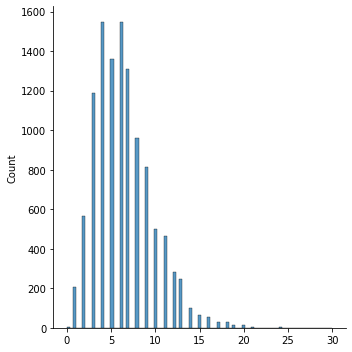

In [15]:
# subject을 길이 분포를 확인한다.
n_len = [len(sub) for sub in subject_idx]
sns.displot(n_len)
plt.show()

In [16]:
# 문장 길이를 맞추고, 학습 데이터를 생성한다.
x_data = pad_sequences(subject_idx, maxlen=15,
                       padding='post', truncating='post')
y_data = topic

In [17]:
# 학습 데이터와 시험데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)


In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((9051, 15), (9051, 1), (2263, 15), (2263, 1))

In [19]:

# LSTM 모델을 생성한다.
EMB_SIZE = 32
VOCAB_SIZE = len(word2idx) + 1
x_input = Input(batch_shape=(None, x_train.shape[1]))
x_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
x_embed = Dropout(0.5)(x_embed)
x_lstm = LSTM(64, dropout=0.5)(x_embed)
y_output = Dense(n_topic, activation='softmax')(x_lstm)

model = Model(x_input, y_output)     # 학습, 예측용 모델
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.005))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 32)            174752    
_________________________________________________________________
dropout (Dropout)            (None, 15, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
Total params: 200,884
Trainable params: 200,884
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 모델을 학습한다.
hist = model.fit(x_train, y_train, validation_data=(
    x_test, y_test), batch_size=512, epochs=50)


Epoch 1/50
18/18 [==============================] - 4s 115ms/step - loss: 2.9473 - val_loss: 2.7646
Epoch 2/50
18/18 [==============================] - 1s 82ms/step - loss: 2.5967 - val_loss: 2.4026
Epoch 3/50
18/18 [==============================] - 1s 78ms/step - loss: 2.2259 - val_loss: 2.0040
Epoch 4/50
18/18 [==============================] - 1s 82ms/step - loss: 1.8875 - val_loss: 1.7132
Epoch 5/50
18/18 [==============================] - 1s 80ms/step - loss: 1.6606 - val_loss: 1.5414
Epoch 6/50
18/18 [==============================] - 1s 81ms/step - loss: 1.4965 - val_loss: 1.3906
Epoch 7/50
18/18 [==============================] - 1s 80ms/step - loss: 1.3526 - val_loss: 1.2530
Epoch 8/50
18/18 [==============================] - 1s 83ms/step - loss: 1.2366 - val_loss: 1.1447
Epoch 9/50
18/18 [==============================] - 1s 83ms/step - loss: 1.1230 - val_loss: 1.0877
Epoch 10/50
18/18 [==============================] - 2s 84ms/step - loss: 1.0514 - val_loss: 1.0328
Epoch 11

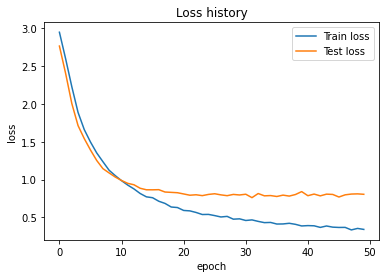

In [21]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [22]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 83.38 %
